In [1]:
!pip install segmentation_models_pytorch
!pip install albumentations==0.4.6

In [2]:

import os, cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

# Define Some parameters
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

# Hyperparameteres
RESIZE_HEIGHT = 500
RESIZE_WIDTH = 500
CROP_HEIGHT = 256
CROP_WIDTH = 250
BATCH_SIZE=32

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


In [4]:

class VOCDataset(torch.utils.data.Dataset):

    """ Pascal VOC2012 Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        mode (String) : is it train or validation dataset
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. crop, resize, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)

    """

    def __init__(
            self,
            mode='train',
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.mode = mode

        # define directory where train and val pictures names are stored
        self.root_path = 'drive/MyDrive/AI/datasets/VOC/VOCdevkit/VOC2012/'
        self.names_path = self.root_path + 'ImageSets/Segmentation/'+ self.mode +'.txt'

        # define image and labels path
        self.image_path = self.root_path + 'JPEGImages/'
        self.label_path = self.root_path + 'SegmentationClass/'

        self.names = []
        self.read_names()

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_path + self.names[i] + '.jpg'), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.label_path + self.names[i] + '.png'), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        image = torch.from_numpy(image).to(DEVICE)
        mask = torch.from_numpy(mask).to(DEVICE)
        return image, mask

    def __len__(self):
        # return length of
        return len(self.names)
        
    def read_names(self):
        """
        Read the filenames of training images and labels into self.names
        """
        f = open(self.names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n','')
            if line is None or len(line) == 0 :
                break
            self.names.append(line)
        f.close()


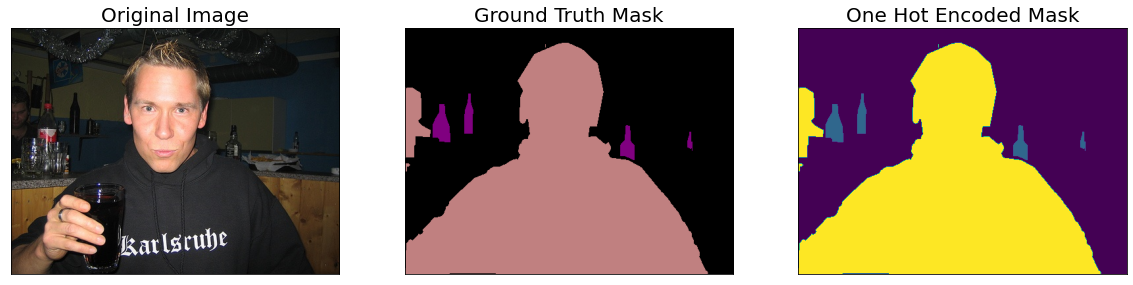

In [5]:

# plot one image/label from dataset
dataset = VOCDataset(class_rgb_values=VOC_COLORMAP)
image, mask = dataset[5]
image = image.cpu().numpy()
mask = mask.cpu().numpy()

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), VOC_COLORMAP),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [6]:

def get_training_augmentation():
    train_transform = [
        album.Resize(height=RESIZE_HEIGHT, width=RESIZE_WIDTH),
        album.RandomCrop(height=CROP_HEIGHT, width=CROP_WIDTH, always_apply=True),  
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        album.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        album.Resize(height=256, width=256),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


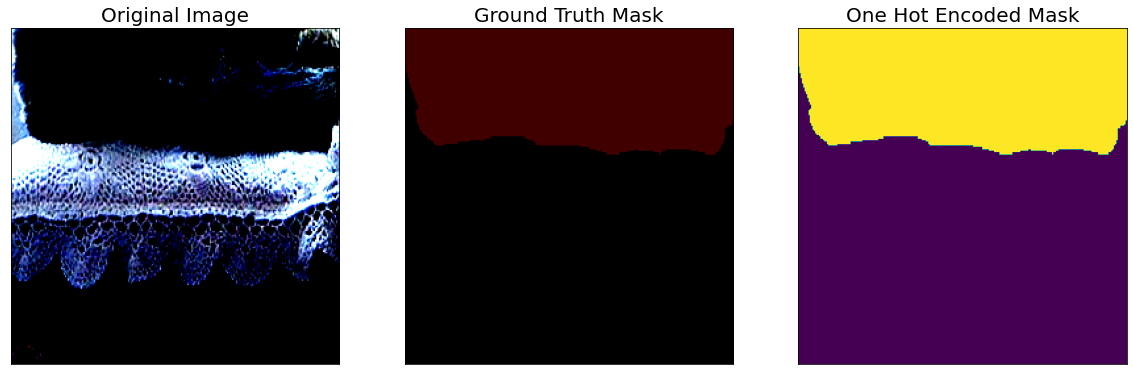

In [7]:

# plot augmented image/label
augmented_dataset = VOCDataset(
    augmentation=get_training_augmentation(),
    class_rgb_values=VOC_COLORMAP,
)

random_idx = random.randint(0, len(augmented_dataset)-1)


image, mask = augmented_dataset[random_idx]
image = image.cpu().numpy()
mask = mask.cpu().numpy()
visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), VOC_COLORMAP),
    one_hot_encoded_mask = reverse_one_hot(mask)
)



In [8]:

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = VOC_CLASSES
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
).to(DEVICE)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [9]:

# Get train and val dataset instances
train_dataset = VOCDataset(
    mode='train',
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=VOC_COLORMAP,
)

valid_dataset = VOCDataset(
    mode='val',
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=VOC_COLORMAP,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)


In [10]:

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = False

# Set num of epochs
EPOCHS = 10

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

# define learning rate scheduler 
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-4,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('drive/MyDrive/AI/voc2012_unet_v1.pth'):
    model = torch.load('drive/MyDrive/AI/voc2012_unet_v1.pth', map_location=DEVICE)
    print("Model was loaded")



Model was loaded


In [11]:

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)


In [12]:

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, 'drive/MyDrive/AI/voc2012_unet_v1.pth')
            print('Model saved!')



In [13]:
best_model = torch.load('drive/MyDrive/AI/voc2012_unet_v1.pth', map_location=DEVICE)
print('Loaded UNet model from this run.')


Loaded UNet model from this run.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


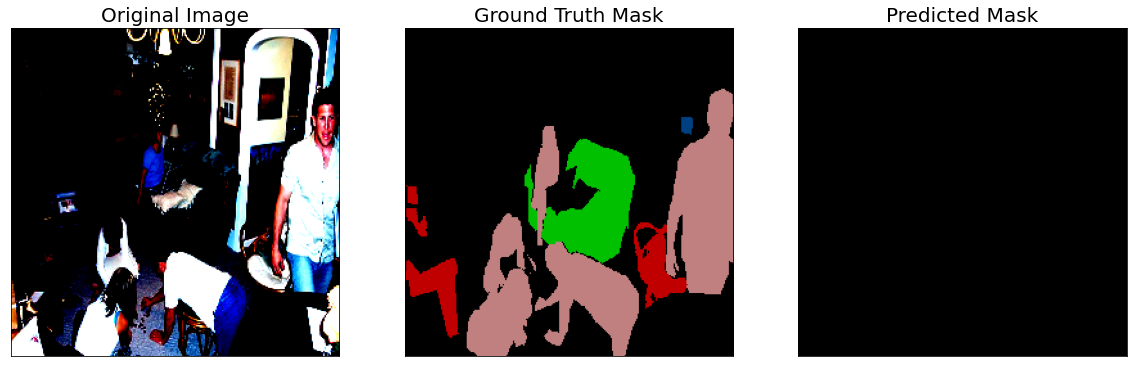

In [14]:

image, mask = valid_dataset[255]
predicted = best_model(image.to(DEVICE).unsqueeze(0))
predicted = predicted.detach().squeeze().cpu().numpy()
visualize(
    original_image = image.cpu().numpy().transpose(1,2,0),
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask.cpu().numpy().transpose(1,2,0)), VOC_COLORMAP),
    predicted_mask = colour_code_segmentation(reverse_one_hot(predicted.transpose(1,2,0)), VOC_COLORMAP),
    )
# it keeps overfitting on background class.